In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
import os

os.getcwd().split("/")[-1]
pdf_path = (
    "/".join(os.getcwd().split("/")[:-1]) + "/" + "data/Bank_eStmt_2025-07-14.pdf"
)

In [4]:
from pydantic import BaseModel

from doc_intelligence.llm import OpenAILLM
from doc_intelligence.processer import DocumentProcessor

In [5]:
llm = OpenAILLM()

In [6]:
processor = DocumentProcessor.from_digital_pdf(
    uri="https://example-files.online-convert.com/document/pdf/example.pdf", llm=llm
)

In [7]:
class License(BaseModel):
    license_name: str

In [8]:
config = {
    "response_format": License,
    "llm_config": {
        "model": "gpt-5-mini",
        "reasoning": {"effort": "minimal"},
    },
    "extraction_config": {
        "include_citations": True,
        "extraction_mode": "single_pass",
        "page_numbers": [0, 1],
    },
}

In [9]:
response = processor.extract(config)

2026-02-11 18:12:50.176 | INFO     | doc_intelligence.processer:parse:47 - Document parsed successfully
2026-02-11 18:12:50.177 | DEBUG    | doc_intelligence.extractor:extract:48 - DigitalPDFExtractor: extract: json_instance_schema: {
    "license_name": {
        "value": <string>,
        "citations": [{"page": <integer>, "lines": [<integer>]}]
    }
}
2026-02-11 18:12:50.177 | INFO     | doc_intelligence.formatter:format_document_for_llm:53 - Formatting 1 pages
2026-02-11 18:12:50.177 | DEBUG    | doc_intelligence.extractor:extract:54 - DigitalPDFExtractor: extract: content_text: <page number=0>
0: PDF test file
1: Purpose: Provide example of this file type
2: Document file type: PDF
3: Version: 1.0
4: Remark:
5: Example content:
6: The names "John Doe" for males, "Jane Doe" or "Jane
7: Roe" for females, or "Jonnie Doe" and "Janie Doe" for
8: children, or just "Doe" non-gender-specifically are used as
9: placeholder names for a party whose true identity is un-
10: known or must be w

In [10]:
response

{'extracted_data': License(license_name='Attribution-ShareAlike 3.0 Unported'),
 'metadata': {'license_name': {'value': 'Attribution-ShareAlike 3.0 Unported',
   'citations': [{'page': 0,
     'bboxes': [{'x0': 0.20106913928643427,
       'top': 0.8587326111744586,
       'x1': 0.5648947389639185,
       'bottom': 0.8718454960091222}]}]}}}

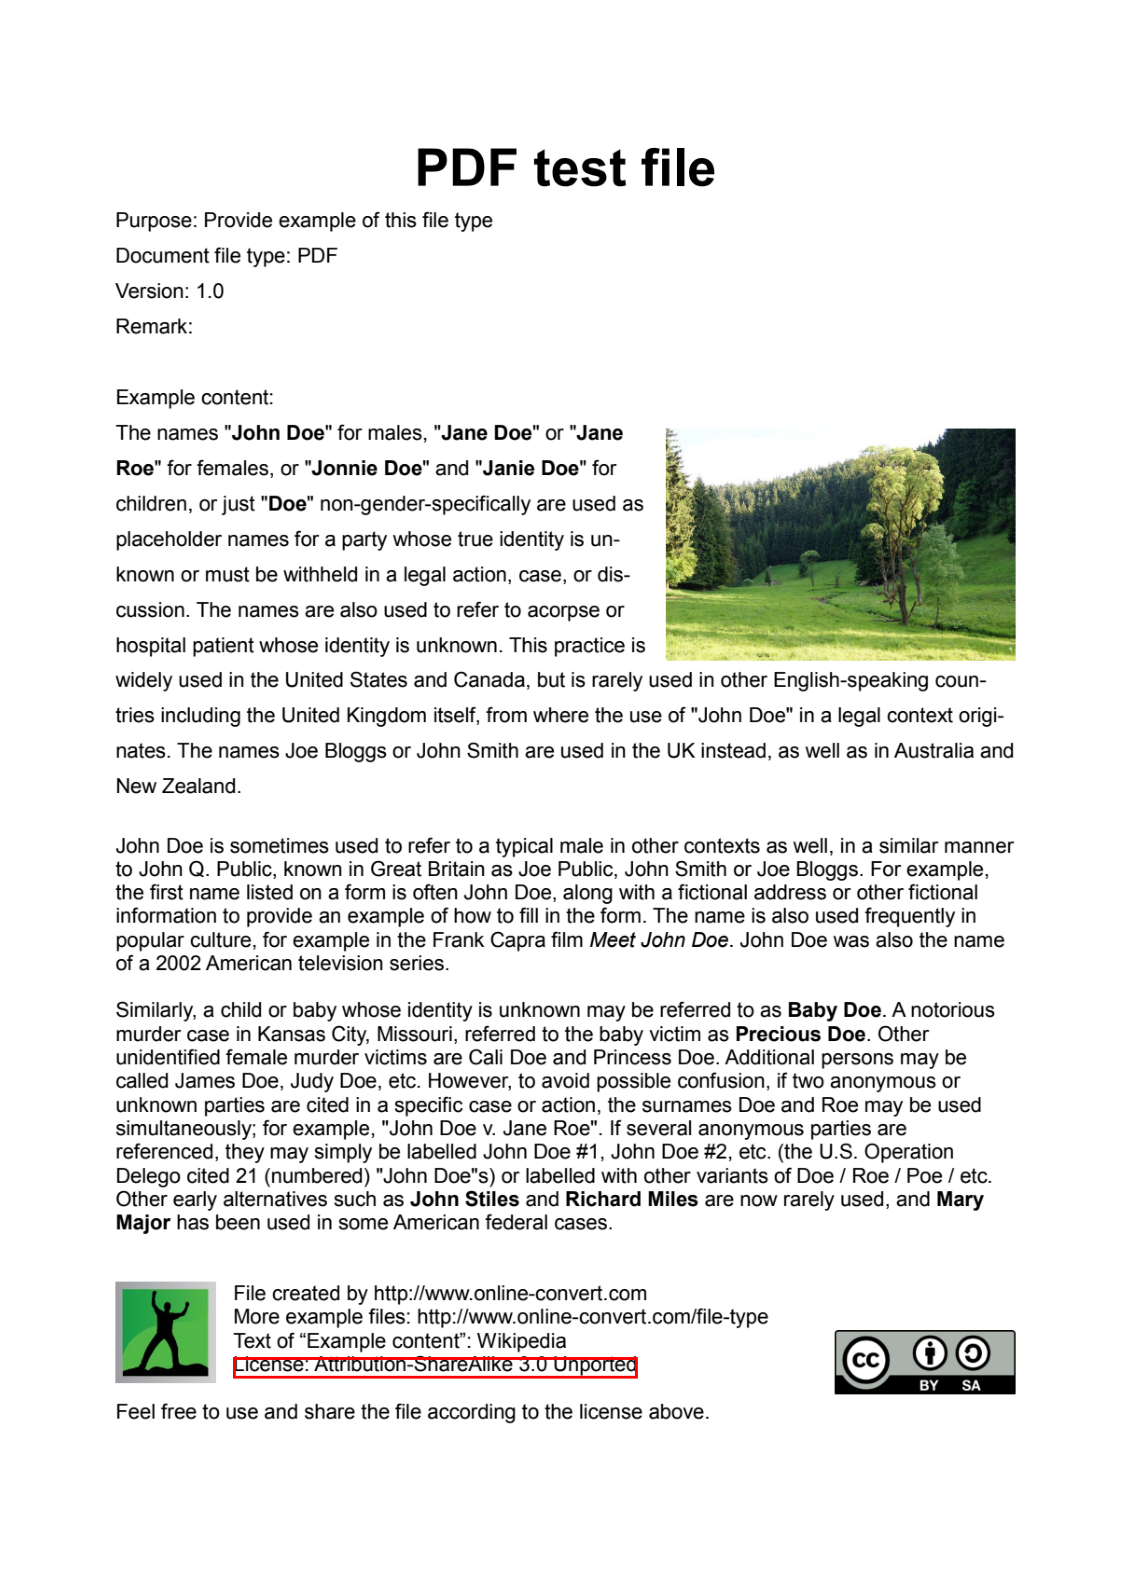

In [11]:
from io import BytesIO
from typing import Dict, List
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import pypdfium2 as pdfium
import requests
from PIL import Image, ImageDraw


def show_pdf_with_bboxes(
    pdf_path: str,
    data: Dict,
    bbox_color: str = "red",
    bbox_width: int = 3,
    scale: float = 2.0,
    figsize: tuple = (12, 16),
):
    """
    Display a PDF page with highlighted bounding boxes in notebook output.

    Parameters:
    -----------
    pdf_path : str
        Path to the PDF file or URL
    data : Dict
        Dictionary with 'page' (int) and 'bboxes' (list of bbox dicts)
        Example: {'page': 0, 'bboxes': [{'x0': 0.2, 'top': 0.85, 'x1': 0.56, 'bottom': 0.87}]}
    bbox_color : str
        Color for bounding box outlines
    bbox_width : int
        Width of bounding box lines
    scale : float
        Rendering scale (higher = better quality, slower)
    figsize : tuple
        Figure size for matplotlib display
    """
    # Extract page and bboxes from data dict
    page = data["page"]
    bboxes = data["bboxes"]

    # Check if pdf_path is a URL or local path
    parsed = urlparse(pdf_path)
    if parsed.scheme in ("http", "https"):
        # Download the PDF from URL
        response = requests.get(pdf_path)
        response.raise_for_status()
        pdf_bytes = BytesIO(response.content)
        pdf = pdfium.PdfDocument(pdf_bytes)
    else:
        # Use local file path
        pdf = pdfium.PdfDocument(pdf_path)

    # Get the specified page
    page_obj = pdf[page]

    # Render page to PIL Image
    pil_image = page_obj.render(scale=scale).to_pil()

    # Get image dimensions
    width, height = pil_image.size

    # Create drawing context
    draw = ImageDraw.Draw(pil_image)

    # Draw each bounding box
    for bbox in bboxes:
        # Convert normalized coordinates to pixel coordinates
        x0_px = bbox["x0"] * width
        y0_px = bbox["top"] * height
        x1_px = bbox["x1"] * width
        y1_px = bbox["bottom"] * height

        # Draw rectangle
        draw.rectangle(
            [(x0_px, y0_px), (x1_px, y1_px)], outline=bbox_color, width=bbox_width
        )

    # Display using matplotlib
    plt.figure(figsize=figsize)
    plt.imshow(pil_image)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Clean up
    page_obj.close()
    pdf.close()


# Example usage - pass your dict directly:
data = {
    "page": 0,
    "bboxes": [
        {
            "x0": 0.20106913928643427,
            "top": 0.8587326111744586,
            "x1": 0.5648947389639185,
            "bottom": 0.8718454960091222,
        }
    ],
}

show_pdf_with_bboxes(
    "https://example-files.online-convert.com/document/pdf/example.pdf",
    response["metadata"]["license_name"]["citations"][0],
)